In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from hp_pred.experiments import load_labelized_cases
from hp_pred.test_model import TestModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load and format data

In [11]:
# import the data frame and add the meta data to the segments

dataset_name = '30_s_filtered_v2_dataset'
# dataset_name = 'chu_dataset'
model_filename = 'xgb_30_s_filter_v2.json'
model_filename_2 = 'xgb_30_s_remi.json'
feature_type="time"

In [12]:
data_clean = pd.read_parquet(f'data/datasets/{dataset_name}/cases', dtype_backend='pyarrow')
if feature_type == "wave" or feature_type == "mixt":
    data_wave = pd.read_parquet(f'data/datasets/{dataset_name}/wave_rocket_features/')
    data_clean = data_clean.merge(data_wave, left_on=['caseid', 'time'], right_on=['caseid', 'Time'])
    data_clean['label'] = data_clean['label_x']

static_clean = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')

data_clean = data_clean.merge(static_clean, on='caseid')
# test = data_clean[data_clean['caseid'].isin(test_caseid)]
test = data_clean[data_clean['split'] == 'test']

# test['label'] = test['label'] | test['intervention']

## Preprocessing

In [13]:
train = data_clean[data_clean['split'] == 'train']
train = train[train['intervention'] == 0]

test = data_clean[data_clean['split'] == 'test']
test = test[test['intervention'] == 0]
#remove points at the end of the procedures when propo, remi and mac are null

# print(f"len test before filter: {len(test)} with a prevalence of {test['label'].mean():.2%}")
# print(f"Number of points removed label as hypotenstion: {test['label'].sum()}")
# test = test[~((test['pp_ct_constant_60'] == 0) & (test['rf_ct_constant_60'] == 0) & (test['mac_constant_60'] == 0))]
# print(f"len test after filter: {len(test)} with a prevalence of {test['label'].mean():.2%}")
# print(f"Number of points removed label as hypotenstion: {test['label'].sum()}")

Number of points in the test data: 64419
Prevalence of hypotension: 5.82%
Test data loaded
Baseline test:


100%|██████████| 200/200 [00:28<00:00,  7.12it/s]


Model test:


100%|██████████| 200/200 [00:44<00:00,  4.44it/s]


Model test:


100%|██████████| 200/200 [00:44<00:00,  4.51it/s]




Results for vdb_filter
Baseline
----- General stats -----
AUC: 0.78 (0.00)
AP: 0.19 (0.00)
AUPRC: 0.23 (0.01)
----- At threshold stats -----
Threshold: 0.22 [0.20, 0.22]
Recall: 23.4% [22.5%, 30.6%]
Precision: 32.2% [31.1%, 33.3%]
Specificity: 95.4% [95.0%, 96.1%]
NPV: 99.6% [99.5%, 99.6%]
F1-score: 27.4% [26.4%, 30.5%]


Model 0
----- General stats -----
AUC: 0.85 (0.00)
AP: 0.31 (0.01)
AUPRC: 0.43 (0.01)
----- At threshold stats -----
Threshold: 0.45 [0.44, 0.46]
Recall: 23.4% [23.4%, 23.5%]
Precision: 55.4% (2.7%)
Specificity: 98.1% (0.2%)
NPV: 99.6% (0.0%)
F1-score: 32.9% (0.5%)


Model 1
----- General stats -----
AUC: 0.85 (0.00)
AP: 0.30 (0.01)
AUPRC: 0.40 [0.39, 0.41]
----- At threshold stats -----
Threshold: 0.44 [0.44, 0.45]
Recall: 23.4% [23.4%, 23.5%]
Precision: 49.8% (2.1%)
Specificity: 97.7% (0.2%)
NPV: 99.6% (0.0%)
F1-score: 31.8% (0.4%)




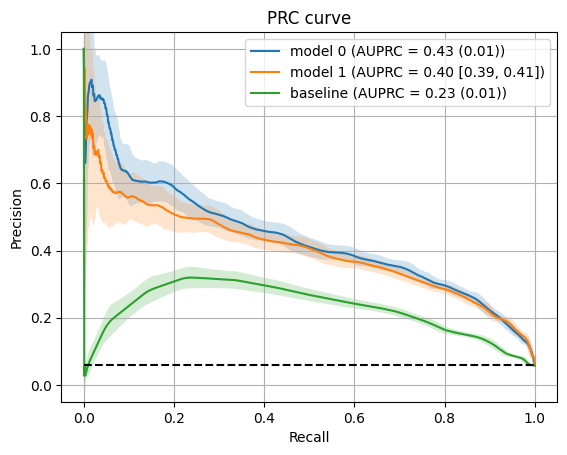

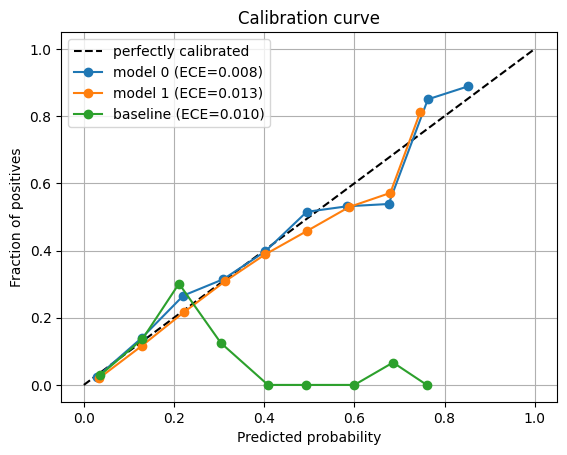

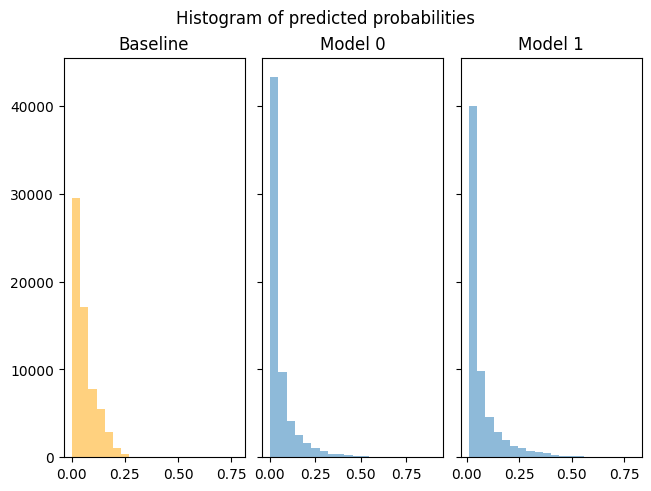

In [14]:
tester = TestModel(
    test,
    train,
    [model_filename, model_filename_2],
    output_name='vdb_filter',
)
tester.run(True, False)

## SHAP interpretations

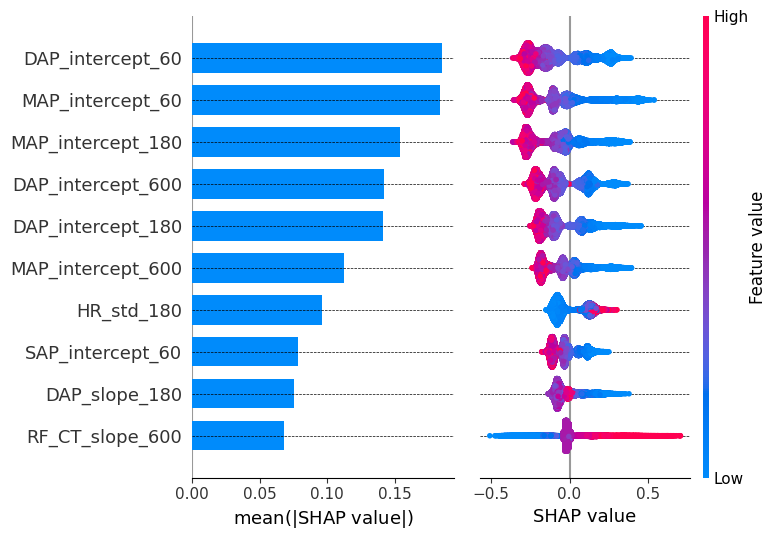

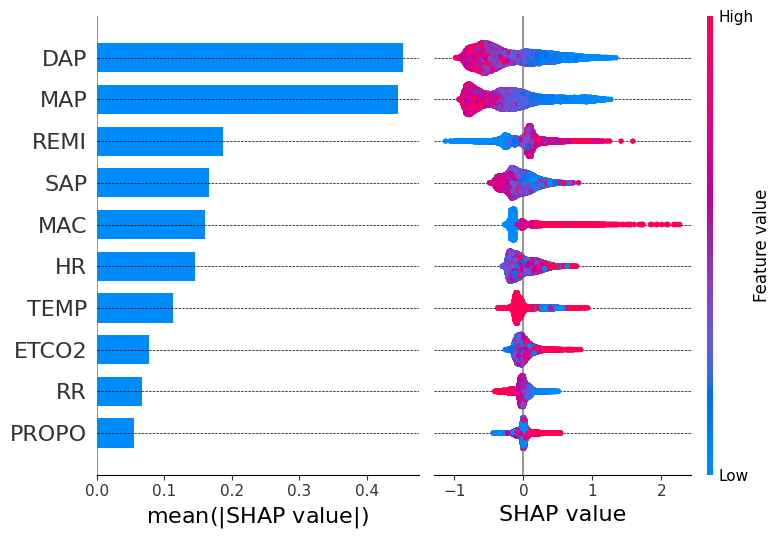

In [15]:
tester.compute_shap_value()
tester.plot_shap_values()
tester.group_shap_values()
tester.plot_shap_grouped()

## exemple of cases


In [16]:
# plot 3 random cases with the corresponding decision function

np.random.seed(1)
cases = np.random.choice(test['caseid'].unique(), 5, replace=False)
model =tester.model
features_names = tester.features_names
for case in cases:
    raw_case = load_labelized_cases(dataset_path=Path(f'data/datasets/{dataset_name}/'), caseid=int(case))

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=features_names)
    x_test = segment_data[features_names]
    y_pred = model.predict_proba(x_test)[:,1]

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIXME: raw_case.mbp might be NaN. fillna(0) ?
    plt.plot(raw_case.index.seconds /60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot([t.hour * 60 + t.minute + t.second /60 for t in (segment_data[segment_data.label>0].time)] ,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot([t.hour * 60 + t.minute + t.second / 60 for t in (segment_data[segment_data.label==00].time)] ,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    # plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')

    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()




AttributeError: 'list' object has no attribute 'predict_proba'